In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import random

In [3]:
import urllib.request

In [4]:
def getNum(img):
    img = img[:,:,::-1]
    boolen = (img[:,:,0]-(img[:,:,1]/2+img[:,:,2]/2)) < 21
    boolen.reshape((*boolen.shape,1))
    boolen = np.stack((boolen,boolen,boolen),2)
    imgn = img.copy()
    imgn[boolen] = 255
    
    boolen = imgn[:,:,0] >= 21
    boolen.reshape((*boolen.shape,1))
    boolen = np.stack((boolen,np.zeros(boolen.shape,np.bool),np.zeros(boolen.shape,np.bool)),2)
    imgn[boolen] = 255
    imgn[imgn>200] = 255
    
    imgn_blur = cv2.GaussianBlur(imgn,(5,5),0)
    img_r = (255 - imgn_blur)[:,:,1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    opened = cv2.morphologyEx(img_r, cv2.MORPH_OPEN, kernel,iterations=2)
    
    return img_r,opened

def resizePic(img,size=(60,20)):
    return cv2.resize(img, size)

def findArea(img):
    arr = []
    for i in range(img.shape[1]):
        if img[:,i].sum() >= 255:
            if len(arr) == 0:
                arr.append(i)
                arr.append(img.shape[1]-1)
            else:
                arr[1] = i
    return arr[0],arr[1]

def divArea(img):
    imgMin, imgMax = findArea(img)
    img = img.copy()
    img[img<50] = 0
    step = (imgMax - imgMin)/4
    idx = np.linspace(imgMin, imgMax, 5).astype('int32')
    arr = []
    for i in range(3):
        index = idx[1+i]
        index = int(index - step//2)
        arrx = []
        for j in range(int(step)):
            k = index + j
            pev = img[:,k-1].sum()
            pre = img[:,k].sum()
            time = max(pev,pre) / (min(pev,pre) + 0.01)
            if time > 5 and (pev > 100 or pre >100):
                arrx.append([k,time])
        arrx.append([idx[1+i],5])
        for k in range(len(arrx)):
            if arrx[k][0] - idx[1+i] <= 3 or idx[2+i] - arrx[k][0] <= 3:
                arrx[k][1] = 4
        arrx.sort(key=lambda x:x[1],reverse=True)
        arr.append(arrx[0][0])
    return [imgMin, *arr, imgMax]

In [5]:
def showPic(img):
    res, res_opened = getNum(img)
    res_resize = resizePic(res)
    a = divArea(res_resize)
    plt.subplot(211)
    plt.imshow(res_resize,cmap='gray')
    for i in range(4):
        plt.subplot(245+i)
        plt.imshow(res_resize[:,a[0+i]:a[1+i]+1],cmap='gray')

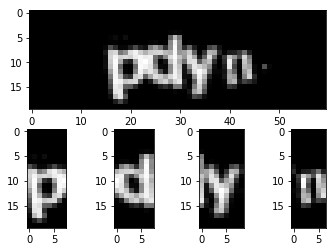

In [18]:
showPic(cv2.imread('8.jpg'))

In [28]:
def showPic_opencv(img):
    res, res_opened = getNum(img)
    res_resize = resizePic(res)
    a = divArea(res_resize)
    for i in range(4):
        img2save = res_resize[:,a[0+i]:a[1+i]+1]
        cv2.imshow('pic',img2save)
        k = cv2.waitKey(0)
        cv2.destroyAllWindows()
        if k != ord('-') and k != ord('='):
            cv2.imwrite('captcha/'+chr(k)+'_'+str(random.random())+'.png',img2save)
        elif k == ord('='):
            return False
    return True


In [26]:
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

In [27]:
img = url_to_image('http://202.115.47.141/img/captcha.jpg')
while showPic_opencv(img):
    img = url_to_image('http://202.115.47.141/img/captcha.jpg')